###1-1.데이터 변형의 개요와 종류

* random crop
* data augmentation :
* translation(평행이동) :
* horizontal flip(좌우대칭) :
* brightness change
* rescale
* random erasing
* bluring
* color noise
* random noise


###1-2. Keras를 이용한 Augmentation

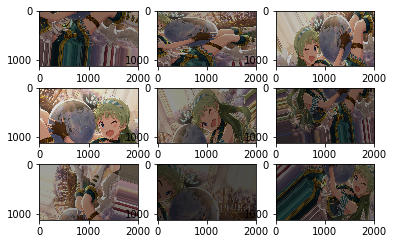

In [5]:
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator #generator는 iterator의 일종. 
import matplotlib.pyplot as plt

# load the image
img= load_img('엘레나 2차 각후.png')

# convert to numpyarray
arr = img_to_array(img)

# expand dimension to one sample
samples = np.expand_dims(arr, 0)

# create image data augmentation generator
# 아래의6개 옵션 중 선택
generated_data = ImageDataGenerator(width_shift_range=[-200,200],
                            height_shift_range=0.5, 
                            horizontal_flip=True, 
                            rotation_range=90, 
                            brightness_range=[0.2,1.0], 
                            zoom_range=[0.5,1.0])


# prepare iterator
iter = generated_data.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # generate batch of images
  batch = iter.next()
  # convert to unsigned integers for viewing
  image = batch[0].astype('uint8')
  # plot raw pixel data
  plt.imshow(image)
# show the figure
plt.show()

###1.3 opencv

In [0]:
import cv2
#RESIZE
def resize_image(image,w,h):
  image=cv2.resize(image,(w,h))
  cv2.imwrite(Folder_name+"/Resize-"+str(w)+"*"+str(h)+Extension, image)
#crop
def crop_image(image,y1,y2,x1,x2):
  image=image[y1:y2,x1:x2]
  cv2.imwrite(Folder_name+"/Crop-"+str(x1)+str(x2)+"*"+str(y1)+str(y2)+Extension,image)
  
def padding_image(image,topBorder,bottomBorder,leftBorder,rightBorder,color_of_border=[0,0,0]):
  image = cv2.copyMakeBorder(image,topBorder,bottomBorder,leftBorder,rightBorder,cv2.BORDER_CONSTANT,value=color_of_border)
  cv2.imwrite(Folder_name+ "/padd-" + str(topBorder) + str(bottomBorder) + "*" + str(leftBorder) + str(rightBorder) + Extension, image)
  
def flip_image(image,dir):
  image = cv2.flip(image, dir)
  cv2.imwrite(Folder_name+ "/flip-" + str(dir) + Extension, image)

def invert_image(image,channel):
  image=cv2.bitwise_not(image)
  image=(channel-image)
  cv2.imwrite(Folder_name+ "/invert-"+ str(channel)+Extension,image)
  
def add_light(image, gamma=1.0):
  invGamma= 1.0 / gamma
  table = np.array([((i / 255.0) ** invGamma) * 255 for i in  np.arange(0, 256)]).astype("uint8")
  image=cv2.LUT(image, table)
  if gamma>=1:
    cv2.imwrite(Folder_name+ "/light-"+ str(gamma)+Extension, image)
  else:
    cv2.imwrite(Folder_name+ "/dark-" + str(gamma) + Extension, image)

def saturation_image(image,saturation):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  v = image[:, :, 2]
  v = np.where(v <= 255 - saturation, v + saturation, 255)
  image[:, :, 2] = v
  image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
  cv2.imwrite(Folder_name+ "/saturation-" + str(saturation) + Extension, image)
  
def scale_image(image,fx,fy):
  image = cv2.resize(image,None,fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)
  cv2.imwrite(Folder_name+"/Scale-"+ str(fx)+str(fy)+Extension, image)
def translation_image(image,x,y):
  rows, cols ,c= image.shape
  M = np.float32([[1, 0, x], [0, 1, y]])
  image = cv2.warpAffine(image, M, (cols, rows))
  cv2.imwrite(Folder_name+ "/Translation-" + str(x) + str(y) + Extension, image)
def rotate_image(image,deg):
  rows, cols,c= image.shape
  M = cv2.getRotationMatrix2D((cols/2,rows/2), deg, 1)
  image = cv2.warpAffine(image, M, (cols, rows))
  cv2.imwrite(Folder_name+ "/Rotate-" + str(deg) + Extension, image)
  
image_file="cat.jpg"
image=cv2.imread(image_file)
resize_image(image,450,400)
crop_image(image,100,400,0,350)
padding_image(image,100,0,0,0)
flip_image(image,0)
invert_image(image,255)
add_light(image,1.5)
add_light_color(image,255,1.5)
saturation_image(image,50)
hue_image(image,50)
translation_image(image,150,150)
rotate_image(image,90)
transformation_image(image)

###2-1 과적합
* 공통적인 특성 외에 지엽적 특성까지 반역해 high variance로 훈련되어 test 데이터에 대해서는 제대로 예측하지 못함

###2-2 정규화

####정규화
* 과적합을 억제하기 위해서 사용하는 기법.
* 손실함수에 가중치의 크기를 포함
*정확도가 적어지는 대신 일반화 정도가 높아지는
* 가중치가 작아지도록 학습한다 = 노이즈에 영향을 덜 받도록 하는것

####L2 norm(유클리드 거리)
* ex)ridge regression

####L1 정규화
* ex)Lasso Regression
* 작은 가중치들이 거의 0으로 수렴하여 몇개의 중요한 가중치들만 남는 경향이 있어서 Sparse 모델에 적합함. ->convex optimization에 유용하게 쓰임(참고적)

*단, L1 Regularization 의 경우 그림처럼미분 불가능한점이 있기 때문에 Gradient-base learning에는 주의가 필요

###2-3. 드랍아웃(Dropout)
* 각 계층마다일정 비율의 뉴런을 임의로 drop시켜 나머지 뉴런들만 학습하는방법
* 드롭아웃을 적용하면 학습되는 노드와 가중치들이 매번 달라져, 과적합을 효과적으로 예방(망 내부의 앙상블 학습으로 볼수 있음)
* 드롭아웃비율은 은닉층50%, 입력층26% 정도가 일반적
* 다른 정규화 기법들과 상호 보완적으로사용 가능
* 역전파는 ReLU처럼 동작
* 순전파 때 신호를 통과시킨 뉴런은 역전파 때도 통과시키고, drop된  뉴런은 역전파 때도 신호를 차단
* Test 때는 모든 뉴런에 신호를 전달한다는것에 주의

###2-4. 배치 정규화(Batch Normalization)

* 학습시 현재 층의 입력은 모든 이전 층의 파라미터의 변화에 영향을 받음
* 망이 깊어짐에 따라 이전 층의 작은 파라미터 변화가 증폭되어 뒷단에 큰 영향을 끼칠수 있음
* 학습하는 이전 층의 파라미터 변화로 현재 층의 입력의 분포가 바뀌는 현상을 내부 공변량 변화(Internal Covariate Shift)라고 함
* 기울기 소실, 기울기 폭발(Exploding)이 일어나지 않도록 한 대표적인 아이디어
* 활성화 함수 변경,  Careful한 초기화, 작은 학습률 설정 등의 간접적인 방법이 아님
* 훈련 과정 자체를 안정화시켜학습속도를가속화한근본적인방법
* 배치 정규화(BN)는 평균과 분산을 조절하는 과정이 별도의 프로세스로 있는 것이 아니라 신경망 안에 포함되어있다는 것이 가장 핵심적인 차이

* Training 시 각 미니배치마다 γ와 β를 구하고 저장해 둠
* Test 시 구했던 γ와 β의 평균을 사용


###실습  : 오버피팅, 언더피팅, 드랍아웃

In [0]:
from keras.layers import Dense
from keras import Sequential
from keras.datasets import imdb
# 100번째 까지 많이 사용하는 단어까지 추출
word_num = 100


(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=word_num)

# 데이터 Shape을 맞춰주기 위한 sequence 함수를 불러옵니다.
train_data = sequences_shaping(train_data, dimension=word_num)
test_data = sequences_shaping(test_data, dimension=word_num)

# 과대적합을 위해 데이터 중 data_num개만 사용
data_num = 400

train_data = train_data[:data_num,:]
test_data = test_data[:data_num,:]
train_labels = train_labels[:data_num]
test_labels =test_labels[:data_num]

# 기본 모델 생성
basic_model = Sequential([
    #summary 메서드 때문에 input_shape가 필요
    #첫 번째 Layer에 데이터를 넣을때는 input_shape에 맞춰줘야 함
    Dense(16, activation=tf.nn.relu, input_shape=(word_num,)),
    Dense(16, activation=tf.nn.relu),
    Dense(1, activation=tf.nn.sigmoid)
])
# 언더피팅 모델 생성
underfitting_model = keras.Sequential([
    keras.layers.Dense(2, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(2, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# 오버피팅 모델 생성
overfitting_model = Sequential([
    Dense(200, activation=tf.nn.relu, input_shape=(word_num,)),
    Dense(200, activation=tf.nn.relu),
    Dense(1, activation=tf.nn.sigmoid)
])

# 최적화 방법, loss 계산 방법, 평가 방법(metrics)을 설정
basic_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', 'binary_crossentropy'])
# 모델이 어떻게 이루어져있는지 출력
basic_model.summary()
# 모델 학습
basic_hist = basic_model.fit(train_data,train_labels,epochs=20,batch_size=500,validation_data=(test_data, test_labels), verbose=2)


underfitting_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', 'binary_crossentropy'])
underfitting_model.summary()
# epoch를 낮춰 언더피팅
underfitting_hist = underfitting_model.fit(train_data, train_labels, epochs=10, batch_size=500, validation_data=(test_data, test_labels),verbose=2)


overfitting_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', 'binary_crossentropy'])
overfitting_model.summary()
# Epoch를 두배로 늘려 학습시켜 오버피팅시킴
overfitting_hist = overfitting_model.fit(train_data, train_labels, epochs=40, batch_size=500, validation_data=(test_data, test_labels),verbose=2)

#plt.figure(figsize=(,20))

data_num = 20000 # for dropout

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=word_num)

train_data = sequences_shaping(train_data, dimension=word_num)
test_data = sequences_shaping(test_data, dimension=word_num)

train_data = train_data[:data_num,:]
test_data = test_data[:data_num,:]
train_labels = train_labels[:data_num]
test_labels =test_labels[:data_num]

dropout_model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dropout(0.25),

    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(0.25),
    
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

dropout_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', 'binary_crossentropy'])
dropout_model.summary()

dropout_hist = dropout_model.fit(train_data, train_labels, epochs=20, batch_size=500, validation_data=(test_data, test_labels),verbose=2)


histories=[('basic', baseline_hist),('Underfitting', underfitting_hist),('Overfitting',overfitting_hist),('Dropout',dropout_hist)]



for name, history in histories :
  val = plt.plot(history.epoch, history.history['val_'+'binary_crossentropy'],
             '--', label=name.title()+' Val')
  plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
       label=name.title()+' Train')

plt.xlabel('Epochs')
plt.ylabel(key.replace('_',' ').title())
plt.legend()

plt.xlim([0,max(history.epoch)])
      
plt.show()
    